# LAMMPS Tutorials 04. Uniaxial compression simulation!

### Author: Mark Tschopp, mark.a.tschopp.civ at mail.mil

Please contact me if you have a problem with this tutorial, so I can modify in Github.  I have added FAQs, and will update my versions of LAMMPS in the future to keep the scripts current.

The latest version of this [Jupyter Notebook](http://ipython.org/notebook.html) tutorial is available at https://github.com/mrkllntschpp/lammps-tutorials.

The original tutorials are given here: https://icme.hpc.msstate.edu/mediawiki/index.php/LAMMPS_tutorials.  A number of these tutorials are out of date and have been ported over into the current iPython Jupyter Notebook tutorials on github.

Acknowledgment: I'd like to acknowledge Nathan Rhodes for generating the original Wiki tutorial.  Thanks Nathan!

***
## Abstract:
<a id="Sec1"></a>

This example script shows how to run an atomistic simulation of uniaxial tensile loading of an aluminum single crystal oriented in the $<100>$ direction. This example uses a parallel molecular dynamics code, LAMMPS [1]. These scripts were initially used to study dislocation nucleation in single crystal aluminum and copper [2-4].  This example uses the Mishin et al. [5] aluminum potential.  The deformation movies were created using OVITO [6] and AtomEye [7] visualization tools.

<br>
<table width="700" border="0" cellpadding="5">
<tr>

<td width="200" align="center" valign="center">
<figure>
  <img src="https://icme.hpc.msstate.edu/mediawiki/images/1/16/Al_comp_100.jpg" width="200" title="Stress-strain curve for uniaxial tensile loading of single crystal aluminum">
</figure>
</td>

<td width="200" align="center" valign="center">
<figure>
  <img src="https://icme.hpc.msstate.edu/mediawiki/images/b/bd/Al_comp_10K_108k.gif" width="200" title="FCC Dislocation nucleation at 10 K">
</figure>
</td>

<td width="200" align="center" valign="center">
<figure>
  <img src="https://icme.hpc.msstate.edu/mediawiki/images/d/d3/Al_comp_108k2.gif" width="200" title="FCC Dislocation nucleation at 300 K" />
</figure>
</td>
</tr>
</table>

***
## Complete the First Tutorials

If you have not done so already, complete the first three tutorials available [here](https://github.com/mrkllntschpp/lammps-tutorials). 

***
## Description of Simulation 
This LAMMPS [1] molecular dynamics simulation first generates a simulation cell with fcc atoms with $<100>$ orientations in the x, y, and z-directions. For this example, the simulation cell size is 10 lattice units in each direction for 4,000 total atoms, 20 units for 32,000 atoms, and 30 units for 108,000 atoms. Larger simulation cell sizes should be used to converge the dislocation nucleation stress values and to not influence the dislocation nucleation mechanism. The potential used in the Mishin *et al.* (1999) aluminum potential [5]. The equilibration step allows the lattice to expand to a temperature of 300 K with a pressure of 0 bar at each simulation cell boundary. Then, the simulation cell is deformed in the x-direction at a strain rate of 10$^{10}$ s$^{-1}$, while the lateral boundaries are controlled using the NPT equations of motion to zero pressure. The stress and strain values are output to a separate file, which can be imported in a graphing application for plotting. The cfg dump files include the x, y, and z coordinates, the centrosymmetry values, the potential energies, and forces for each atom. This can be directly visualized using OVITO [6] and AtomEye [7] visualization tools. 

## Step 1: Create the LAMMPS input script 
This input script was run using the January 2020 version of LAMMPS. Changes in some commands may require revision of the input script. This script runs the simulation with 4,000 atoms. To change the number of atoms, alter the numbers (currently 10) after the `region` command under the `Atom Definition` subsection of the input script. To run this script, store it in `in.comp.txt` and then use `lmp_exe < in.comp.txt` in a UNIX environment where `lmp_exe` refers to the LAMMPS executable.  Notice that the only difference, besides file names, between this script and the script for uniaxial tension is the negative in the definition of variable `srate1`.

In [1]:
%%writefile in.comp.txt
######################################
# LAMMPS INPUT SCRIPT
# Input file for uniaxial compressive loading of single crystal aluminum
# Mark Tschopp
# Syntax "lmp_exe < in.comp.txt" from command prompt

######################################
# INITIALIZATION
units metal
dimension 3
boundary p p p
atom_style atomic
variable latparam equal 4.05

######################################
# ATOM DEFINITION
lattice fcc ${latparam} orient x 1 0 0 orient y 0 1 0 orient z 0 0 1
region whole block 0 10 0 10 0 10
create_box 1 whole
create_atoms 1 region whole

######################################
# DEFINE INTERATOMIC POTENTIAL
pair_style eam/alloy
pair_coeff * * Al99.eam.alloy Al

######################################
# DEFINE COMPUTES 
compute csym all centro/atom fcc
compute peratom all pe/atom 

######################################
# EQUILIBRATION
reset_timestep 0
timestep 0.001
velocity all create 300 12345 mom yes rot no
fix 1 all npt temp 300 300 1 iso 0 0 1 drag 1 

# Set thermo output
thermo 1000
thermo_style custom step lx ly lz press pxx pyy pzz pe temp

# Run for at least 10 picosecond (assuming 1 fs timestep)
run 20000
unfix 1

# Store final cell length for strain calculations
variable tmp equal "lx"
variable L0 equal ${tmp}
print "Initial Length, L0: ${L0}"

######################################
# DEFORMATION
reset_timestep 0

fix 1 all npt temp 300 300 1 y 0 0 1 z 0 0 1 drag 1
variable srate equal 1.0e10
variable srate1 equal "-v_srate / 1.0e12"
fix 2 all deform 1 x erate ${srate1} units box remap x

# Output strain and stress info to file
# for units metal, pressure is in [bars] = 100 [kPa] = 1/10000 [GPa]
# p2, p3, p4 are in GPa
variable strain equal "(lx - v_L0)/v_L0"
variable p1 equal "v_strain"
variable p2 equal "-pxx/10000"
variable p3 equal "-pyy/10000"
variable p4 equal "-pzz/10000"
fix def1 all print 100 "${p1} ${p2} ${p3} ${p4}" file Al_comp_100.def1.txt screen no

# Use cfg for AtomEye
dump 1 all cfg 250 dump.comp_*.cfg mass type xs ys zs c_csym c_peratom fx fy fz
dump_modify     1 element Al

# Display thermo
thermo 1000
thermo_style custom step v_strain temp v_p2 v_p3 v_p4 ke pe press

run 20000

######################################
# SIMULATION DONE
print "All done"

Overwriting in.comp.txt


So far so good. You should have the file in your working directory if you are running this from Jupyter Notebook.

## Step 2: Run the Simulation

Now run the simulation as we have done before.  On my computer, the 24Jan2020 LAMMPS executable is stored in the `C:\Program Files\LAMMPS 64-bit 24Jan2020\bin\` folder and is named `lmp_serial.exe`.  The `log.lammps` file should look like the output below. Notice that the 20 ps (20,000 fs) equilibration step brought the temperature of the simulation cell up to 300 K. The corresponding deformation went up to a strain of 0.2. The thermo command was set for every 1000 timesteps, so any plots should be made from the data included in the datafile.

<br>
<div class="alert alert-danger">
Warning! This next simulation can take a little time to execute on a laptop or desktop (approximately 15 minutes or so).  Here is where you start to appreciate the ability to use multiple processors to break up the spatial domain of your simulations.  And this is just a small toy simulation... 
</div>

In [ ]:
!"C:/Program Files/LAMMPS 64-bit 24Jan2020/bin/lmp_serial" < in.comp.txt

The `log.lammps` file should look like that above. Notice that the 20 ps (20,000 fs) equilibration step brought the temperature of the simulation cell up to 300 K. The corresponding deformation went up to a strain of 0.20. The thermo command was set for every 1000 timesteps, so any plots should be made from the data included in the datafile. 

As with the tensile example, additional commands were added to produce files beyond just the `log.lammps` file.  Notice that there are `dump.comp_XXXX.cfg` files (for visualization purposes) and a LAMMPS datafile `Al_comp_100.def1.txt` (short for Al/Aluminum, comp/compression, 100 for $<100>$ tensile direction.  These were the product of including the following lines to the input script:

`fix def1 all print 100 "${p1} ${p2} ${p3} ${p4}" file Al_comp_100.def1.txt screen no`

`dump 1 all cfg 250 dump.comp_*.cfg mass type xs ys zs c_csym c_peratom fx fy fz`

For instance, here is what they look like:

In [2]:
# If this works, that would be great: !cat Al_comp_100.def1.txt
f = open('Al_comp_100.def1.txt', 'r')
file_contents = f.read()
print (file_contents)
f.close()

# Fix print output for fix def1
-1.04876770108941e-15 0.006544204941825 0.0112769288118514 0.0184296850870927
-0.00100000000000116 -0.0853550160851663 -0.0286113809558465 -0.0107775728523962
-0.00200000000000093 -0.124374847000587 0.0115339961169419 -0.000842864987771222
-0.00300000000000104 -0.222390889739451 -0.0234353471774952 0.0205230117067471
-0.00400000000000116 -0.275158926661491 0.0134960511371104 0.0191974250050772
-0.00500000000000092 -0.318062465365302 0.0108369766337521 0.0236688839396363
-0.00600000000000103 -0.414600723540492 -0.0111473354470806 -0.00256521843916366
-0.00700000000000115 -0.448419076607791 0.0163440401146079 -0.0110385514833013
-0.00800000000000091 -0.538586399541433 -0.0288139229940203 -0.0149058260017884
-0.00900000000000103 -0.577108111389922 0.0049119796467491 -0.00919287367418519
-0.0100000000000011 -0.657387249714805 0.0168298033917989 -0.0369791633924296
-0.0110000000000009 -0.717742108293957 -0.0198442312721714 0.0163926126650005
-0.01200000000000

In [3]:
# If this works, that would be great: !cat dump.comp_0.cfg
f = open('dump.comp_0.cfg', 'r')
file_contents = f.read()
print (file_contents)
f.close()

Number of particles = 4000
A = 1 Angstrom (basic length-scale)
H0(1,1) = 40.6501 A
H0(1,2) = 0 A 
H0(1,3) = 0 A 
H0(2,1) = 0 A 
H0(2,2) = 40.6501 A
H0(2,3) = 0 A 
H0(3,1) = 0 A 
H0(3,2) = 0 A 
H0(3,3) = 40.6501 A
.NO_VELOCITY.
entry_count = 8
auxiliary[0] = c_csym
auxiliary[1] = c_peratom
auxiliary[2] = fx
auxiliary[3] = fy
auxiliary[4] = fz
26.982000 
Al 
0.0512719 0.0463412 0.00471191 1.45669 -3.31471 0.0900081 0.473863 -0.544048 
26.982000 
Al 
0.00276101 0.0495094 0.0489156 0.51257 -3.32493 -0.282763 -0.229385 0.244644 
26.982000 
Al 
0.101208 0.0503832 0.051736 0.275394 -3.28837 -0.439154 -0.177426 -0.271738 
26.982000 
Al 
0.0482082 0.100248 0.0517863 0.218181 -3.34786 -0.01032 -0.0511796 -0.342577 
26.982000 
Al 
0.100135 0.0997173 0.00201337 0.283332 -3.32337 -0.408122 0.0954105 0.0340656 
26.982000 
Al 
0.0503231 0.048285 0.103087 0.639918 -3.30581 -0.172117 -0.0304571 -0.297089 
26.982000 
Al 
0.104218 0.000575278 0.101837 0.546107 -3.29553 -0.371481 -0.416292 -0.263148 
26.9

***
## Step 3: Post-Processing the Simulation 

So, now what?  Why don't we open the `Al_SC_100.def1.txt` file for a stress-strain curve, and then visualize the data from the cfg files to see what is happening with the atoms.

### Stress-Strain Plot Using MATLAB

The stress-strain curve in Figure 1 can be generated using the MATLAB script provided in Tutorial 3, with one modification:
`d = dir('Al_comp_100.def1.txt');`
As with earlier, the exportfig command refers to a script on MATLAB Central File website. You will need to go to the website and download the script into the current directory for this to work.  Both the compression and tension stress-strain curves are shown in Figures 1a and 1b, respectively.

There. Easy enough.  Note that with that script, if there are multiple `*.def1.txt` files, MATLAB will take each one, plot it, save the plot as a tif file, and cycle through all of them.

<table width="800" border="0" cellpadding="5">
<tr>

<td width="350" align="center" valign="center">
<figure>
  <img src="https://icme.hpc.msstate.edu/mediawiki/images/1/16/Al_comp_100.jpg" width="300" title="Stress-strain curve for uniaxial compressive loading of single crystal aluminum">
  <figcaption><strong>Figure 1a.</strong> Stress-strain curve for uniaxial compressive loading of single crystal aluminum in the $<100>$ loading direction.
</figcaption>
</figure>
</td>

<td width="350" align="center" valign="center">
<figure>
  <img src="https://icme.hpc.msstate.edu/mediawiki/images/d/d7/Al_SC_100_stress-strain.jpg" width="300" title="Stress-strain curve for uniaxial tensile loading of single crystal aluminum">
  <figcaption><strong>Figure 1b.</strong> Stress-strain curve for uniaxial tensile loading of single crystal aluminum in the $<100>$ loading direction.
</figcaption>
</figure>
</td>
</tr>
</table>

### Stress-Strain Plot Using Python

Or, you can make something in Python:

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import csv

results = []
with open('Al_comp_100.def1.txt',newline='') as file:
    reader = csv.reader(file, delimiter=' ')
    next(reader)  # Skip header row.
    for row in reader:
        row2 = [float(i) for i in row]
        results.append(row2)
        # print(row2)

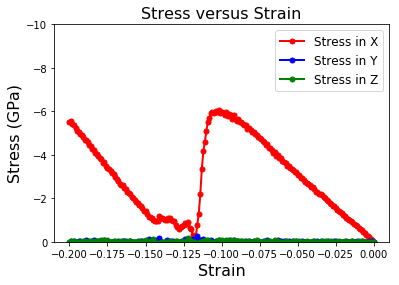

In [5]:
results2 = np.transpose(results)
plt.plot(results2[0],results2[1], '-or', label='Stress in X', lw=2, markersize = 5, mec = 'r', mfc = 'r')
plt.plot(results2[0],results2[2], '-ob', label='Stress in Y', lw=2, markersize = 5, mec = 'b', mfc = 'b')
plt.plot(results2[0],results2[3], '-og', label='Stress in Z', lw=2, markersize = 5, mec = 'g', mfc = 'g')
plt.xlabel('Strain',fontsize=16)
plt.ylabel('Stress (GPa)',fontsize=16)
plt.title('Stress versus Strain',fontsize=16)
plt.legend(fontsize=12)
plt.axis(aspect='equal')
plt.ylim(0,-10)
plt.show()


Hmm.  Well, note that the strain is negative and the stress/pressure is also negative.  So, if you want to recast this plot into a positive "compressive" stress and strain, you can just multiple everything by "-1".

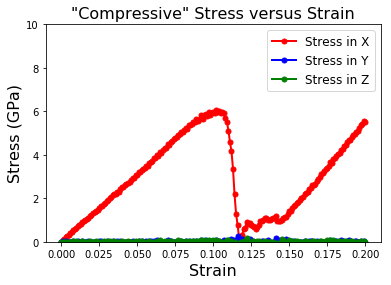

In [6]:
results2 = -1*np.transpose(results)
plt.plot(results2[0],results2[1], '-or', label='Stress in X', lw=2, markersize = 5, mec = 'r', mfc = 'r')
plt.plot(results2[0],results2[2], '-ob', label='Stress in Y', lw=2, markersize = 5, mec = 'b', mfc = 'b')
plt.plot(results2[0],results2[3], '-og', label='Stress in Z', lw=2, markersize = 5, mec = 'g', mfc = 'g')
plt.xlabel('Strain',fontsize=16)
plt.ylabel('Stress (GPa)',fontsize=16)
plt.title('"Compressive" Stress versus Strain',fontsize=16)
plt.legend(fontsize=12)
plt.axis(aspect='equal')
plt.ylim(0,10)
plt.show()

Why doesn't this look like the MATLAB plot?  See the FAQ below.

***
## Step 4: Making the Deformation Movie 

OK, so there are a far greater number of different software visualization packages out there now than there were a decade ago.  I used to use AtomEye almost exclusively for visualization.  I then found ways to visualize things in MATLAB, where I could add a lot of different elements.  I would suggest downloading OVITO and trying it out, but there are a number of different packages.  The AtomEye and ImageJ thread of the tutorial is from a long time ago.  

### Visualization in Windows with OVITO

First download [OVITO](https://www.ovito.org/).
* Go to [OVITO](https://www.ovito.org/).
* Click on download, select operating system, and then create username to download.  Follow remaining instructions to get it on yoru computer.

OK.  Here goes:
* Open [OVITO](https://www.ovito.org/)
* Load file and select the `dump.comp_0.cfg` file.  OVITO will find the rest of the `*.cfg` files.
* Drag the slider bar at the bottom to `64/80` because that is about where the peak of the stress-strain curve above appears.
* Now, go to the `Add modification...` pull down list and select `Color coding`.  Now go to the bottom `Particle property` pulldown list and select `c_csym`.  Now click on adjust range to get a start and end value that is reasonable for viewing the dislocation.
* Click on the play button below to view the evolution of the deformation process.
* To create a movie, click on the `Render Active Viewport` tab up above.  In the `Rendering range` box, select `Complete animation`.  Click on `Save to file` and click on the `Choose...` button (name, "deformation-movie.png").  I like transparent background.  Then click on `Render Active Viewport` at the top for it to render the animation.
* Use ImageJ or whatever you like to pull all the images together into an animated gif or the like to create a movie file.

**Try this!** For this example, let's try something different.  Go to the `Add modification...` list and use the "Common Neighbor Analysis" modifier to visualize dislocations.  Select all atoms with low CNA value and delete these atoms from the view.  Redo everything else. Choose different bounds in order to try to visualize the dislocations.  That probably worked much better, huh?  This example shows that not all atom-based metrics show what you need to see.  Some are definitely better than others, which is why there are a number of different metrics that can be used to observe different phenomena in different material systems.

<table width="800" border="0" cellpadding="5">
<tr>

<td width="350" align="center" valign="center">
<figure>
  <img src="https://icme.hpc.msstate.edu/mediawiki/images/0/0a/Al_comp_dislocation_4k.jpg" width="300" title="Image of nucleated dislocation near peak stress">
  <figcaption><strong>Figure 2.</strong> Image of nucleated dislocation near peak stress.
</figcaption>
</figure>
</td>

<td width="350" align="center" valign="center">
<figure>
  <img src="https://icme.hpc.msstate.edu/mediawiki/images/1/12/Al_comp_4k.gif" width="300" title="Movie showing compressive deformation of single crystal aluminum">
  <figcaption><strong>Figure 3.</strong> Movie showing compressive deformation of single crystal aluminum loaded in the $<100>$ direction at a strain rate of 10$^{10}$ s$^{-1}$ and a temperature of 300 K. Only atoms in non-centrosymmetric environment are shown.
</figcaption>
</figure>
</td>
</tr>
</table>

### Visualization in UNIX with AtomEye

First download [AtomEye](http://mt.seas.upenn.edu/Archive/Graphics/A/). 
* Go to [AtomEye](http://mt.seas.upenn.edu/Archive/Graphics/A/) website at http://mt.seas.upenn.edu/Archive/Graphics/A/. 
* Click on Download, this will take you to the raw binary files. 
* Download the A.i686 version by right-clicking on the link and "Save Target As..." to one of your directories. 
* Rename the downloaded file as A by typing "cp A.i686 A". A will be the executable. 
* Using UNIX, run "chmod A 755" on the file to change this to an executable. 
* To test, you need to save a CFG file as well, such as cnt8x3.cfg. Try running using "./A cnt8x3.cfg". 

Next download [ImageJ](http://rsbweb.nih.gov/ij/). 
* Go to [ImageJ](http://rsbweb.nih.gov/ij/) website at http://rsbweb.nih.gov/ij/. 
* Download the appropriate version for Windows, LINUX, or MAC. 

This assumes that you already have AtomEye and ImageJ downloaded and installed. 
* Visualize the dumpfile in AtomEye by typing the following command, "/A dump.tensile_0.cfg" (UNIX). 
* Use the AtomEye options to select how you want to visualize deformation. In this example, the centrosymmetry parameter was used to show only atoms in a non-centrosymmetric environment (see Fig. 2). 
    * Use Alt+0 to activate centrosymmetric (csym) view. 
    * Adjust threshold, or set of atoms to view, by using Shift+T. This will allow creation of a set for the current parameter (in this case, csym). Please note that you need to adjust both lower and higher thresholds unless the atoms from following images that exceeds maximum value for the first one will be not shown. You can make it 5 or 10. 
    * Make atoms with values outside of the threshold invisible by using Ctrl+A. 
* Press 'y' within AtomEye to produce an animation script. 
* The folder "Jpg" now contains snapshots of all dumpfiles. 
* Open ImageJ 
* Drag the folder Jpg into ImageJ 
    * Select "Convert to RGB" to keep the color from the AtomEye images. 
    * Choose "yes" to load a stack. 
* Adjust the size as needed (Image/Adjust/Size) 
* Adjust frame rate as desired (Image/Stacks/Tools/Animation Options) 
* Save as Animated Gif file 
 

## Step 5: Compare the effect of simulation cell size

In order to test the difference that the number of atoms can have on a simulation, the above script was run with 32,000 atoms using `region whole block 0 20 0 20 0 20` and 108,000 atoms using `region whole block 0 30 0 30 0 30`.  Editing the values (currently "10") in the following line in the input script changes the size of the simulation cell and the number of atoms used in the simulation. Values of "20" will result in 32,000 atoms, and values of "30" will result in 108,000 atoms. 

Shown below are movies of the 4,000, 32,000, and 108,000 atom simulations, which show only atoms in a non-centrosymmetric environment. As one might expect, more slip planes become visible as the atom count of the simulation increases. 

<table width="800" border="0" cellpadding="5">
<tr>

<td width="250" align="center" valign="center">
<figure>
  <img src="https://icme.hpc.msstate.edu/mediawiki/images/1/12/Al_comp_4k.gif" width="300" title="Movie showing compressive deformation of single crystal aluminum">
  <figcaption><strong>Figure 4a.</strong> 4,000 atom simulation cell. Movie showing compressive deformation of single crystal aluminum loaded in the $<100>$ direction at a strain rate of 10$^{10}$ s$^{-1}$ and a temperature of 300 K. Only atoms in non-centrosymmetric environment are shown.
</figcaption>
</figure>

<td width="250" align="center" valign="center">
<figure>
  <img src="https://icme.hpc.msstate.edu/mediawiki/images/5/57/Al_comp_108k.gif" width="300" title="Movie showing compressive deformation of single crystal aluminum">
  <figcaption><strong>Figure 4b.</strong> 108,000 atom simulation cell. Movie showing compressive deformation of single crystal aluminum loaded in the $<100>$ direction at a strain rate of 10$^{10}$ s$^{-1}$ and a temperature of 300 K. Only atoms in non-centrosymmetric environment are shown.
</figcaption>
</figure>

</td>
</tr>
</table>

Cool! Note that it's very difficult to capture the exact moment that a dislocation starts to nucleate within the simulation cell. Once it does nucleate, it propagates very rapidly through the periodic simulation and interacts with itself, a potentially-biasing (aphysical?) phenomena.  Even the nucleation event itself is influenced by the number of atomic interactions, the strain rate, etc.  Hence, if we could make the simulation cells as large as possible and could use the smallest strain rate possible, we could assure ourselves that we don't have something occuring within the simulation that is merely a function of our boundary conditions.  Unfortunately, this requires massively parallel simulations on supercomputers.

<br>
<div class="alert alert-warning">
  <strong>Warning!</strong> Don't expect that this will finish on your laptop very quickly.  Here is where you are going to need multiple processors and/or a supercomputer.
</div>

## Step 5: Compare the effect of temperature

The temperature of the simulations also makes a difference in the outputs. To show this difference, the above simulations (previously at 300 K) were run at 10 K. In order to change the temperature of the simulation, three lines in the input script must be edited. Two lie under the `Equilibration` section while the third lies under `Deformation.` 

The velocity and fix commands shown below contain temperature data. The velocity command specifies the thermal velocity of the system while the fix command specifies the desired temperatures at the beginning and end of the simulation. In order to run the simulation at 10 K instead of 300 K, change the three "300" values to "10"' in the velocity and fix command lines. 

<br>
<div class="alert alert-block alert-info">
# EQUILIBRATION  <br>
reset_timestep	0  <br>
timestep 0.001  <br>
velocity all create 10 12345 mom yes rot no  <br>
fix 1 all npt temp 10 10 1 iso 0 0 1 drag 1  <br>
</div>

The temperature values in the fix command under `Deformation` also needs to be changed to "10" instead of "300". The values are being changed again because between `Equilibration` and `Deformation` the fix ID 1 was unfixed. Here fix 1 is being redefined.

<br>
<div class="alert alert-block alert-info">
# DEFORMATION <br>
reset_timestep 0 <br>
fix	1 all npt temp 10 10 1 y 0 0 1 z 0 0 1 drag 1 <br>
</div>

All three simulation cell sizes were run at 10 K. Below are the movies from the simulations. Once again, only atoms in a non-centrosymmetric environment are viewable. The difference between the 300 K and 10 K simulations is that there is less non-centrosymmetry induced by thermal velocity. At 10 K, many fewer atoms are seen before slip occurs, and the slip planes are more cleary visible and absent of "noise" created by atoms that are non-centrosymmetric solely due to thermal activity. 

<br>
<table width="800" border="0" cellpadding="5">
<tr>

<td width="250" align="center" valign="center">
<figure>
  <img src="https://icme.hpc.msstate.edu/mediawiki/images/0/08/Al_comp_10K_4k.gif" width="250" title="Movie showing compressive deformation of single crystal aluminum">
  <figcaption><strong>Figure 5a.</strong> 4,000 atom simulation cell. Movie showing compressive deformation of single crystal aluminum loaded in the $<100>$ direction at a strain rate of 10$^{10}$ s$^{-1}$ and a temperature of 10 K. Only atoms in non-centrosymmetric environment are shown.
</figcaption>
</figure>

<td width="250" align="center" valign="center">
<figure>
  <img src="https://icme.hpc.msstate.edu/mediawiki/images/4/4f/Al_comp_10K_32k.gif" width="250" title="Movie showing compressive deformation of single crystal aluminum">
  <figcaption><strong>Figure 5b.</strong> 32,000 atom simulation cell. Movie showing compressive deformation of single crystal aluminum loaded in the $<100>$ direction at a strain rate of 10$^{10}$ s$^{-1}$ and a temperature of 10 K. Only atoms in non-centrosymmetric environment are shown.
</figcaption>
</figure>


<td width="250" align="center" valign="center">
<figure>
  <img src="https://icme.hpc.msstate.edu/mediawiki/images/b/bd/Al_comp_10K_108k.gif" width="250" title="Movie showing compressive deformation of single crystal aluminum">
  <figcaption><strong>Figure 5c.</strong> 108,000 atom simulation cell. Movie showing compressive deformation of single crystal aluminum loaded in the $<100>$ direction at a strain rate of 10$^{10}$ s$^{-1}$ and a temperature of 10 K. Only atoms in non-centrosymmetric environment are shown.
</figcaption>
</figure>

</td>
</tr>
</table>


<br>
<div class="alert alert-warning">
  <strong>Warning!</strong> Don't expect that this will finish on your laptop very quickly.  Here is where you are going to need multiple processors and/or a supercomputer.
</div>

***
## FAQs 

<br>
<div class="alert alert-danger">
    <strong>Question 1</strong>: I noticed that on the stress-strain curve in the Figure 1, following the peak stress (dislocation nucleation), the stresses are approximately 2 GPa in the strain range 0.1-0.2. However, in the log file and output files for the input script above, the stresses range from 2-6 GPa. Why?  
</div>

Aha! I threw a curveball at you. The plot is actually for a much larger simulation cell. The 4000-atom simulation cell from the above input script is relatively small. Hence, after dislocation nucleation, further plastic deformation becomes very difficult and you will actually see a second curve. For much larger cell sizes (and more atoms), this flow stress following nucleation should begin to look more like the stress-strain curve in Figure 1. This observation also brings up an important point - the behavior and properties calculated using molecular dynamics can sometimes be heavily influenced by the size of the simulation cell (and the strain rate and the potential and the temperature and the boundary conditions). I relate this size dependence in MD simulations to a mesh sensitivity study in finite element models - you should keep increasing the simulation cell size to understand the potential error in your calculations. If you can obtain some degree of convergence in properties or behavior (mechanism), this is the ideal situation. 

***
## Links

* [Click here to open Tutorial 1](LAMMPS-Tutorials-01.ipynb)
* [Click here to open Tutorial 2](LAMMPS-Tutorials-02.ipynb)
* [Click here to open Tutorial 3](LAMMPS-Tutorials-03.ipynb)
* [Click here to open the next tutorial](LAMMPS-Tutorials-05.ipynb)

***
## References 

1. S. Plimpton, "Fast Parallel Algorithms for Short-Range Molecular Dynamics," J. Comp. Phys., 117, 1-19 (1995). 
1. Spearot, D.E., Tschopp, M.A., Jacob, K.I., McDowell, D.L., "Tensile strength of <100> and <110> tilt bicrystal copper interfaces," Acta Materialia 55 (2007) p. 705-714 (http://dx.doi.org/10.1016/j.actamat.2006.08.060). 
1. Tschopp, M.A., Spearot, D.E., McDowell, D.L., "Atomistic simulations of homogeneous dislocation nucleation in single crystal copper," Modelling and Simulation in Materials Science and Engineering 15 (2007) 693-709 (http://dx.doi.org/10.1088/0965-0393/15/7/001). 
1. Tschopp, M.A., McDowell, D.L., "Influence of single crystal orientation on homogeneous dislocation nucleation under uniaxial loading," Journal of Mechanics and Physics of Solids 56 (2008) 1806-1830. (http://dx.doi.org/10.1016/j.jmps.2007.11.012). 
1. Y. Mishin, D. Farkas, M.J. Mehl, and D.A. Papaconstantopoulos, "Interatomic potentials for monoatomic metals from experimental data and ab initio calculations," Phys. Rev. B 59, 3393 (1999). 
1. A. Stukowski, "Visualization and analysis of atomistic simulation data with OVITO – the Open Visualization Tool," Modelling Simul. Mater. Sci. Eng. 18 (2010) 015012.
1. J. Li, "AtomEye: an efficient atomistic configuration viewer," Modelling Simul. Mater. Sci. Eng. 11 (2003) 173. 